## Imporing libiaries and data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# model building
import sklearn as sk
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import math

# pytorch
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

# feature selection
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.base import clone
import gc

## viewing train and test data

In [3]:
train = pd.read_csv('train.csv',index_col='id')
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test = pd.read_csv('test.csv',index_col='id')
test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [5]:
train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [6]:
test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [7]:
pd.DataFrame([train.isna().sum(), test.isna().sum()], index=['train', 'test']).T
# Viewing number of NaN values

,train,test
person_age,0.0,0.0
person_income,0.0,0.0
person_home_ownership,0.0,0.0
person_emp_length,0.0,0.0
loan_intent,0.0,0.0
loan_grade,0.0,0.0
loan_amnt,0.0,0.0
loan_int_rate,0.0,0.0
loan_percent_income,0.0,0.0
cb_person_default_on_file,0.0,0.0


In [8]:
train.nunique()
#Looking for Outliers

person_age                      53
person_income                 2641
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      545
loan_int_rate                  362
loan_percent_income             61
cb_person_default_on_file        2
cb_person_cred_hist_length      29
loan_status                      2
dtype: int64

In [9]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_cols = ['person_age', 'person_income', 'person_emp_length',\
                  'loan_amnt', 'loan_int_rate', 'loan_percent_income',\
                  'cb_person_cred_hist_length']
#encoding in person

In [10]:
for c in categorical_cols:
    print(train[c].value_counts())
    print('__________________________')

person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64
__________________________
loan_intent
EDUCATION            12271
MEDICAL              10934
PERSONAL             10016
VENTURE              10011
DEBTCONSOLIDATION     9133
HOMEIMPROVEMENT       6280
Name: count, dtype: int64
__________________________
loan_grade
A    20984
B    20400
C    11036
D     5034
E     1009
F      149
G       33
Name: count, dtype: int64
__________________________
cb_person_default_on_file
N    49943
Y     8702
Name: count, dtype: int64
__________________________


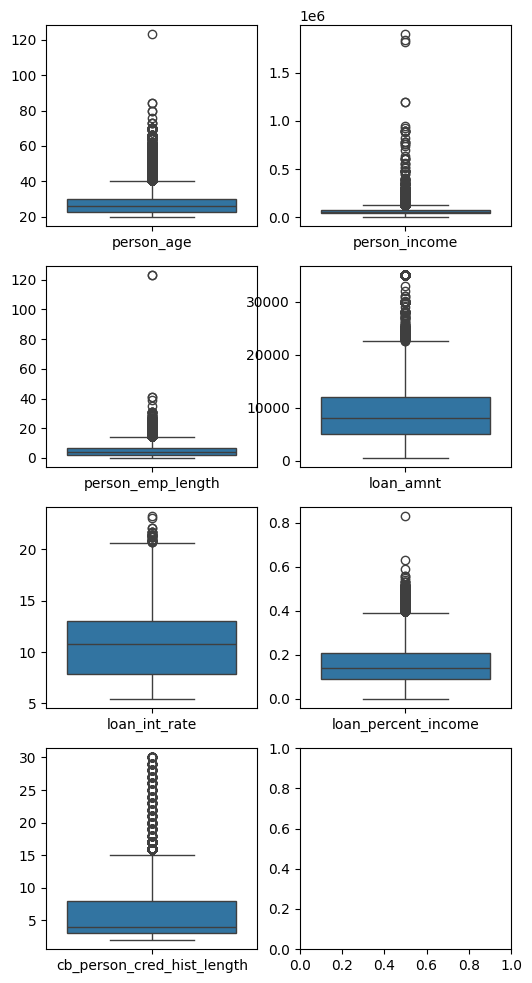

In [11]:
fig, axes = plt.subplots(4, 2, figsize=(3*2,3*4))
def box(i):
    plot = sns.boxplot(train[numerical_cols].iloc[:, [i]], ax=axes[i//2][i%2])
for i in range(7):
        box(i)
plt.show()# Box line charts to assess data stabilization

In [12]:
num_or_float_columns = train.select_dtypes(['int', 'float']).columns
columns = num_or_float_columns[1:-1]  
outlier_dict = {}
new_train = train.copy()

def IQR(column):
    q1 = np.percentile(train[column], 25)
    q3 = np.percentile(train[column], 75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    higher_fence = q3 + 1.5 * iqr
    global new_train
    outliers = new_train[(new_train[column] < lower_fence) | (new_train[column] > higher_fence)]
    new_train = new_train[~((new_train[column] < lower_fence) | (new_train[column] > higher_fence))]
    outlier_dict[column] = outliers
    print(f"Outliers detected for {column}: {len(outliers)}")

for i in columns:
    IQR(i)

print("Before Dropping null values:", train.shape)
print("After Dropping null values:", new_train.shape)


Outliers detected for person_income: 2411
Outliers detected for person_emp_length: 1156
Outliers detected for loan_amnt: 1476
Outliers detected for loan_int_rate: 31
Outliers detected for loan_percent_income: 965
Outliers detected for cb_person_cred_hist_length: 1621
Before Dropping null values: (58645, 12)
After Dropping null values: (50985, 12)


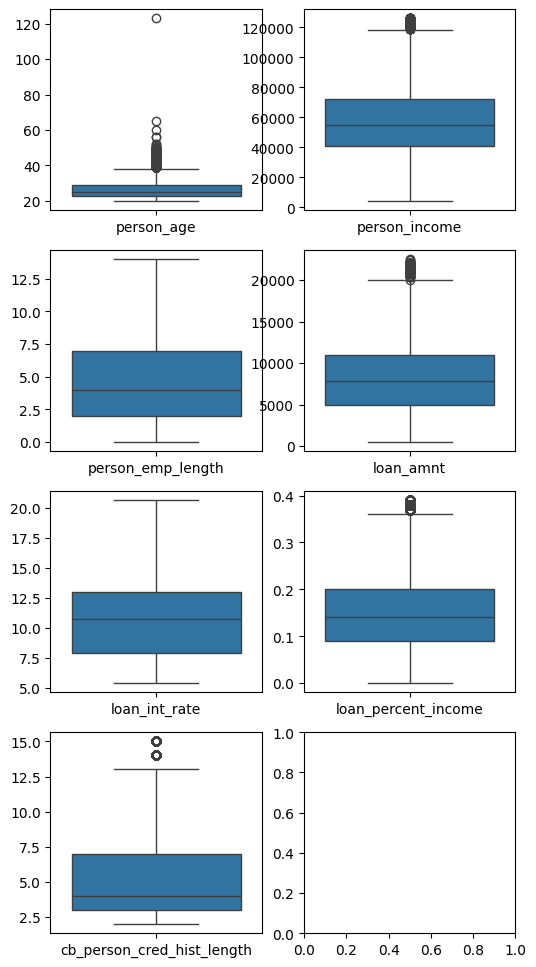

In [13]:
fig, axes = plt.subplots(4, 2, figsize=(3*2,3*4))
def box(i):
    plot = sns.boxplot(new_train[numerical_cols].iloc[:, [i]], ax=axes[i//2][i%2])
for i in range(7):
        box(i)
plt.show()

In [14]:
new_train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,50985.000000,50985.000000,50985.000000,50985.000000,50985.000000,50985.000000,50985.000000,50985.000000
mean,26.731450,58938.140198,4.388879,8388.055350,10.625068,0.153054,5.250878,0.128901
std,4.908061,23196.756508,3.378204,4503.840536,3.010707,0.081254,3.208374,0.335093
min,20.000000,4200.000000,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,41000.000000,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,25.000000,55000.000000,4.000000,7800.000000,10.740000,0.140000,4.000000,0.000000
75%,29.000000,72000.000000,7.000000,11000.000000,12.980000,0.200000,7.000000,0.000000
max,123.000000,126000.000000,14.000000,22500.000000,20.620000,0.390000,15.000000,1.000000


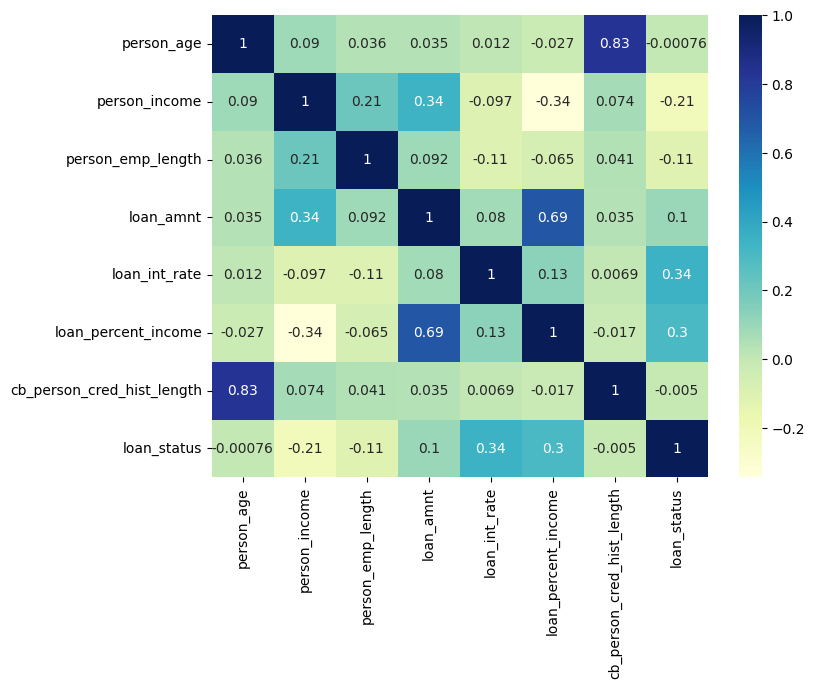

In [15]:
# Plotting correlation heatmap
fig, ax = plt.subplots(figsize=(8,6))
dataplot = sns.heatmap(new_train.corr(numeric_only=True), cmap="YlGnBu", annot=True, ax=ax)

# Displaying heatmap
plt.show()

In [16]:
# droping the target column and 'id' because it isn't a feature
X = new_train.drop(['loan_status'], axis=1)
y = new_train['loan_status']
X.head(2)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=5)

In [18]:
print(pd.DataFrame(y_train).value_counts())

loan_status
0              31168
1               4521
Name: count, dtype: int64


In [19]:
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# define pipeline
over = SMOTENC(sampling_strategy = 0.4, categorical_features=[2, 4, 5, 9],\
               k_neighbors = 100, random_state = 42)
# transform the dataset
X_train, y_train = over.fit_resample(X_train, y_train)

print(pd.DataFrame(y_train).value_counts())

loan_status
0              31168
1              12467
Name: count, dtype: int64


In [20]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [21]:
test_transformed = test.copy()

# prepare output data by converting categories into numbers
oe = OrdinalEncoder()
oe.fit(X_train[categorical_cols])
X_train[categorical_cols] = oe.transform(X_train[categorical_cols])
X_test[categorical_cols] = oe.transform(X_test[categorical_cols])
test_transformed[categorical_cols] = oe.transform(test_transformed[categorical_cols])

Feature 0: 5833.234048
Feature 1: 517.087829
Feature 2: 13445.655391
Feature 3: 0.168390


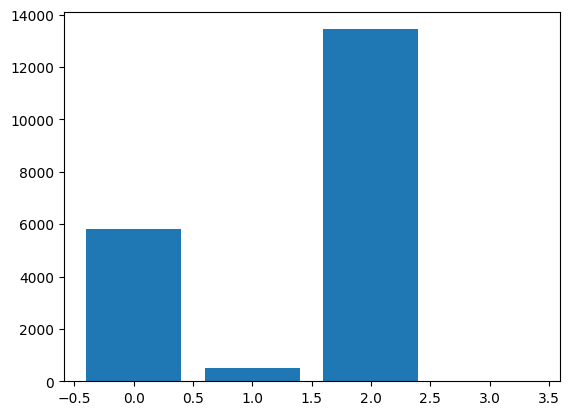

In [22]:
def select_features(X_train, y_train):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs


# applying feature selection on the training data
X_train_fs, fs = select_features(X_train[categorical_cols], y_train)

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [23]:
X_train = X_train.drop(['person_age', 'cb_person_cred_hist_length', 'cb_person_default_on_file'], axis=1)
X_test = X_test.drop(['person_age', 'cb_person_cred_hist_length', 'cb_person_default_on_file'], axis=1)
test_transformed = test_transformed.drop(['person_age', 'cb_person_cred_hist_length', 'cb_person_default_on_file'], axis=1)


## Using bagging and boosting model

### RandomForest

In [24]:
from sklearn.ensemble import RandomForestClassifier##bagging model

In [25]:
model = RandomForestClassifier(
    max_depth=24,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=800,
    random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=24, min_samples_split=10, n_estimators=800,
                       random_state=42)

In [26]:
y_pred = model.predict_proba(X_test)[:, 1]

y_pred

array([0.00427809, 0.0797862 , 0.84341574, ..., 0.00662823, 0.00225694,
       0.03049997])

model 1 AUC score: 0.9361


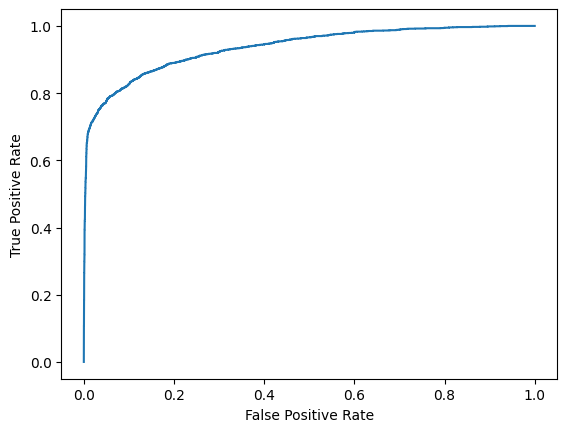

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ROC Area Under Curve (AUC)
print(f'model 1 AUC score: {roc_auc_score(y_test, y_pred):.4f}')

In [28]:
threshold = 0.5
y_pred = np.array((y_pred > threshold)) # 0.0 or 1.0

print(f"Accuracy Score: {accuracy_score(y_test, y_pred)*100:.3f} %")

Accuracy Score: 94.888 %


In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43635 entries, 0 to 43634
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   person_income          43635 non-null  int64  
 1   person_home_ownership  43635 non-null  float64
 2   person_emp_length      43635 non-null  float64
 3   loan_intent            43635 non-null  float64
 4   loan_grade             43635 non-null  float64
 5   loan_amnt              43635 non-null  int64  
 6   loan_int_rate          43635 non-null  float64
 7   loan_percent_income    43635 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 2.7 MB


In [30]:
wrong_preds = X_test[np.logical_xor(y_test, y_pred)]
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade'] 
numerical_cols = ['person_income', 'person_emp_length','loan_amnt', 'loan_int_rate', 'loan_percent_income']
                  
for c in categorical_cols:
    print(wrong_preds[c].value_counts() / X_test[c].value_counts() *100)
    print('__________________________')

person_home_ownership
3.0     6.501139
0.0     3.747535
2.0     0.936768
1.0    19.047619
Name: count, dtype: float64
__________________________
loan_intent
0.0    4.379562
1.0    4.435121
2.0    9.126984
3.0    5.457123
4.0    6.296441
5.0    2.805534
Name: count, dtype: float64
__________________________
loan_grade
0.0     1.993781
1.0     4.637135
2.0     7.778915
3.0    12.339137
4.0    12.851406
5.0    16.666667
6.0    20.000000
Name: count, dtype: float64
__________________________


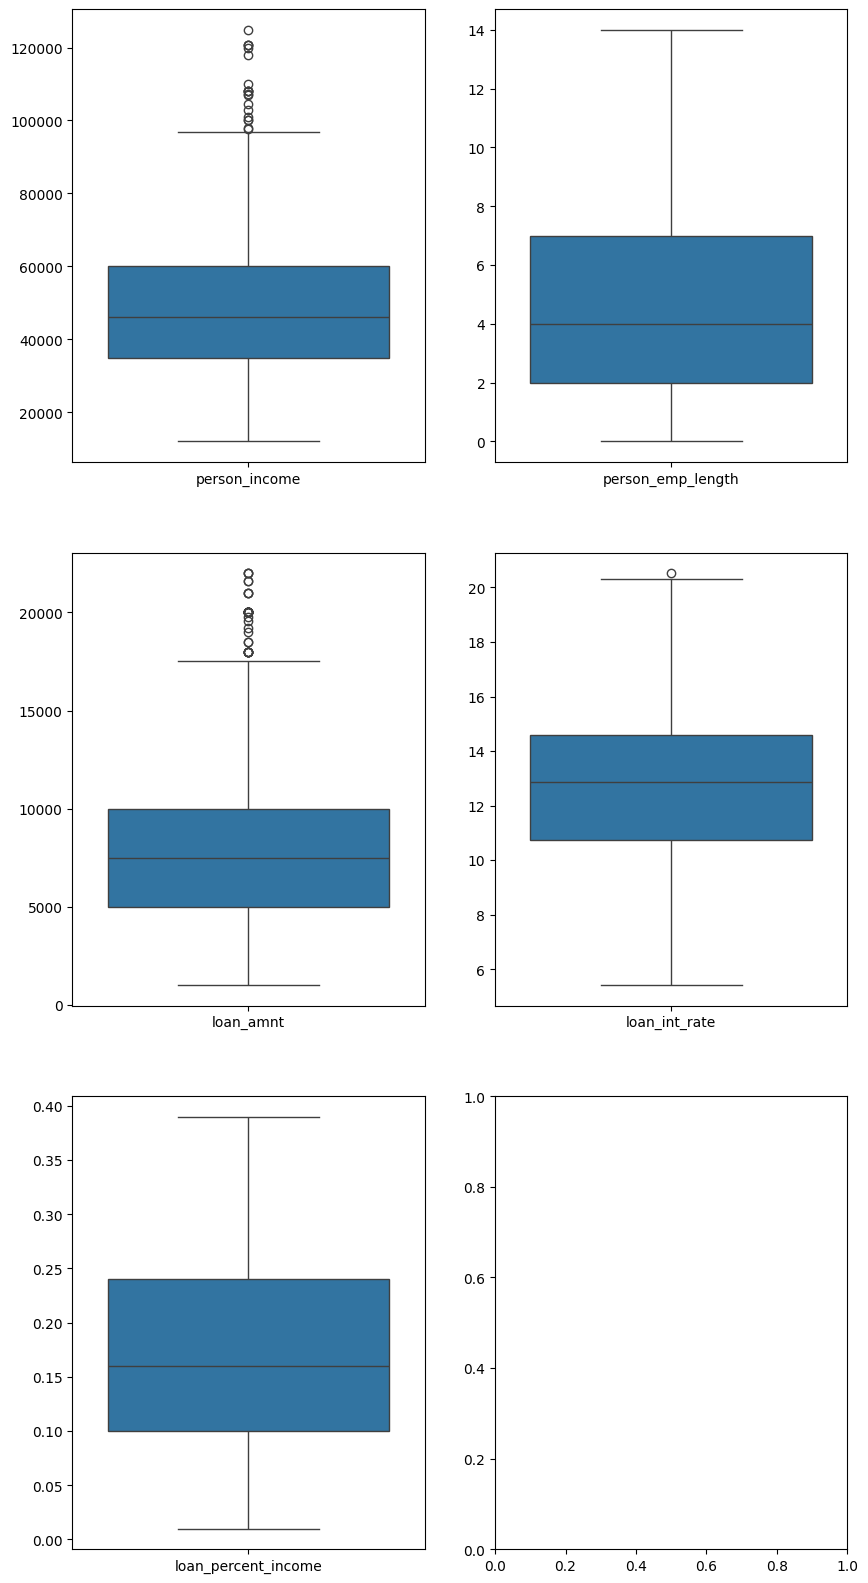

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(5*2,5*4))
def box(i):
    plot = sns.boxplot(wrong_preds[numerical_cols].iloc[:, [i]], ax=axes[i//2][i%2])
for i in range(5):
        box(i)
plt.show()

### LightGBM（Light Gradient Boosting Machine）

In [32]:
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#  LGBMClassifier 
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
#transforming data type back to category
model = lgb.LGBMClassifier(max_depth=24, min_child_samples=1, min_split_gain=0.0, n_estimators=500, random_state=42)

model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 12467, number of negative: 31168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 43635, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285711 -> initscore=-0.916307
[LightGBM] [Info] Start training from score -0.916307


LGBMClassifier(max_depth=24, min_child_samples=1, n_estimators=500,
               random_state=42)

Text(0, 0.5, 'True Positive Rate')

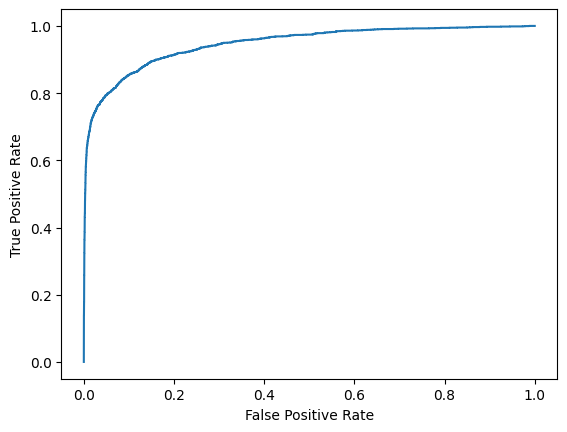

In [33]:
y_pred_lgb = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [34]:
print(f'model 1 AUC score: {roc_auc_score(y_test, y_pred_lgb):.4f}')


threshold = 0.5
y_pred_binary = (y_pred_lgb > threshold).astype(int)


print(f"Accuracy Score: {accuracy_score(y_test, y_pred_binary) * 100:.3f} %")

model 1 AUC score: 0.9468
Accuracy Score: 94.724 %


In [35]:
wrong_preds_lgb = X_test[np.logical_xor(y_test, y_pred_binary)]

In [36]:
print(X_train['person_home_ownership'].value_counts())
print(X_test['person_home_ownership'].value_counts())
print(X_train['loan_grade'].value_counts())
print(X_test['loan_grade'].value_counts())

person_home_ownership
3.0    26802
0.0    14892
2.0     1883
1.0       58
Name: count, dtype: int64
person_home_ownership
3.0    8337
0.0    6084
2.0     854
1.0      21
Name: count, dtype: int64
loan_grade
1.0    14498
0.0    13212
3.0     8259
2.0     7023
4.0      565
5.0       69
6.0        9
Name: count, dtype: int64
loan_grade
0.0    5467
1.0    5305
2.0    2931
3.0    1321
4.0     249
5.0      18
6.0       5
Name: count, dtype: int64


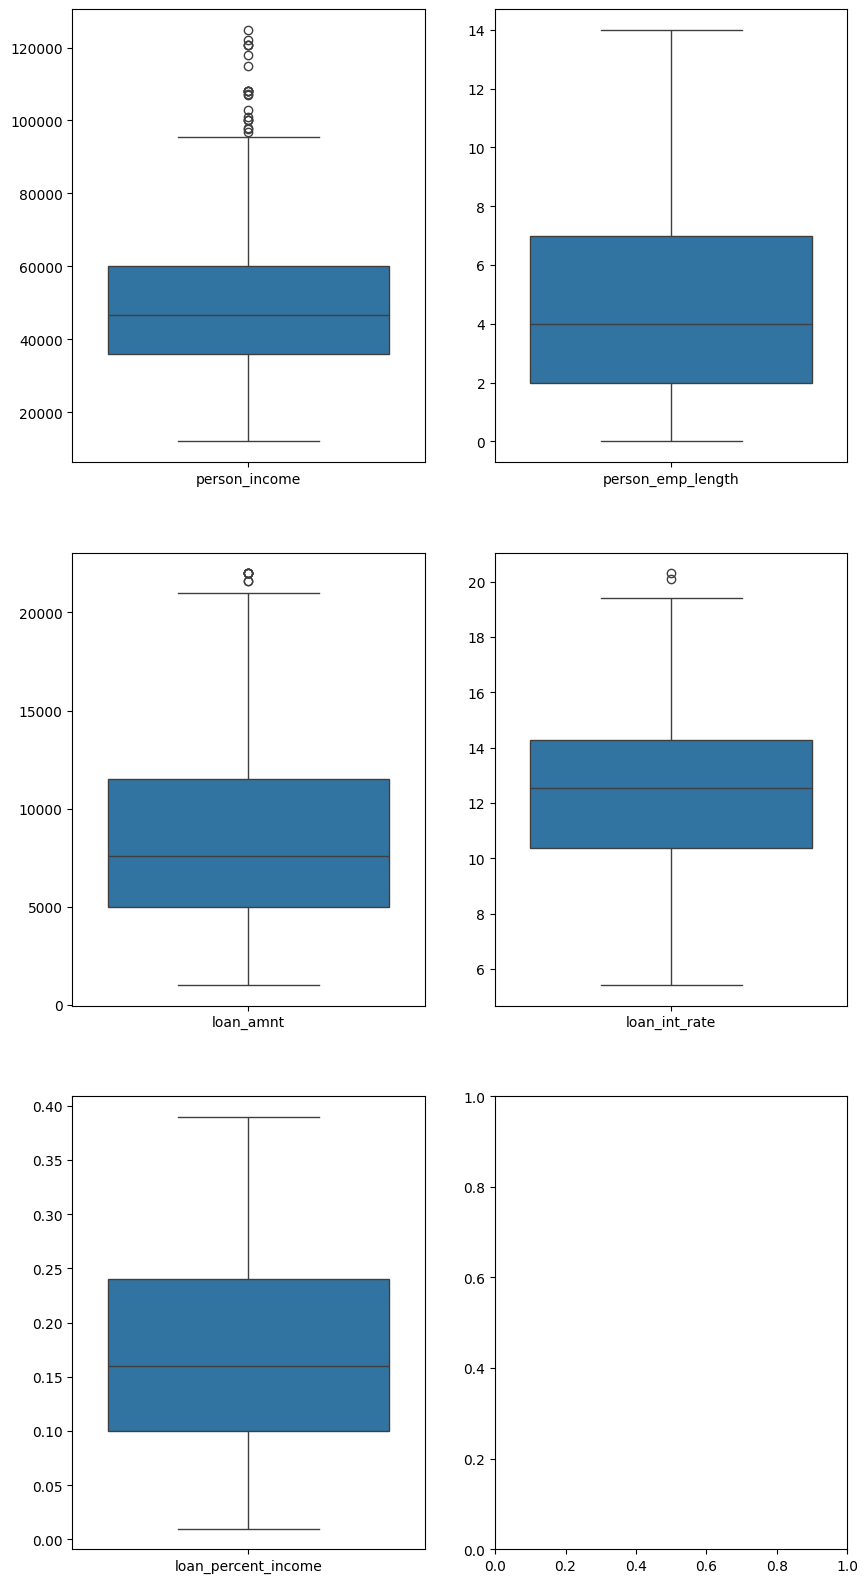

In [37]:
fig, axes = plt.subplots(3, 2, figsize=(5 * 2, 5 * 4))

def box(i):
    plot = sns.boxplot(wrong_preds_lgb[numerical_cols].iloc[:, [i]], ax=axes[i // 2][i % 2])

for i in range(5):
    box(i)

plt.show()

### XGBoost（eXtreme Gradient Boosting）

Text(0, 0.5, 'True Positive Rate')

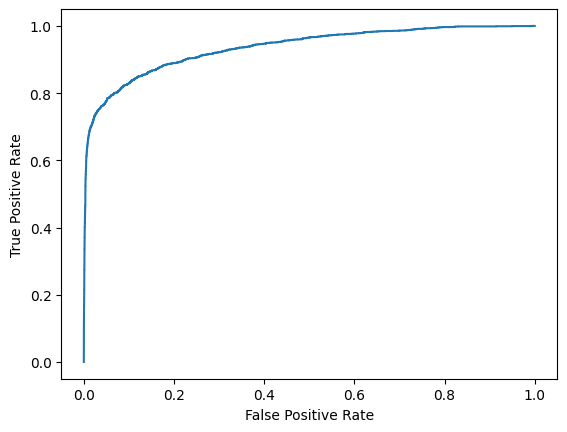

In [38]:
import xgboost as xgb##boosting model
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
# for col in categorical_cols:
#     X_train[col] = X_train[col].astype('category')
#     X_test[col] = X_test[col].astype('category')

model = xgb.XGBClassifier(max_depth=24, min_child_weight=1, learning_rate=0.1, n_estimators=500, random_state=42, enable_categorical=True)
#cuz xgb model do not support the categorical type, using 'enable_categorical=True' to make sure it can go on.
model.fit(X_train, y_train)

y_pred_xgb = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


In [39]:
print(f'model 2 AUC score: {roc_auc_score(y_test, y_pred_xgb):.4f}')

threshold = 0.5
y_pred_binary = (y_pred_xgb > threshold).astype(int)

print(f"Accuracy Score: {accuracy_score(y_test, y_pred_binary) * 100:.3f} %")

model 2 AUC score: 0.9355
Accuracy Score: 94.456 %


In [40]:
wrong_preds_xgb = X_test[np.logical_xor(y_test, y_pred_binary)]

# 打印每个类别的错误预测比例
for c in categorical_cols:
    print(wrong_preds_xgb[c].value_counts() / X_test[c].value_counts() * 100)
    print('__________________________')

person_home_ownership
3.0    7.016913
0.0    4.174885
2.0    0.936768
1.0    4.761905
Name: count, dtype: float64
__________________________
loan_intent
0.0    5.393350
1.0    4.974528
2.0    8.399471
3.0    6.059532
4.0    6.570199
5.0    3.189854
Name: count, dtype: float64
__________________________
loan_grade
0.0     2.085239
1.0     5.372290
2.0     8.665984
3.0    12.112036
4.0    12.851406
5.0    16.666667
6.0     0.000000
Name: count, dtype: float64
__________________________


In [41]:
print(X_train['loan_grade'].value_counts())
print(X_test['loan_grade'].value_counts())

loan_grade
1.0    14498
0.0    13212
3.0     8259
2.0     7023
4.0      565
5.0       69
6.0        9
Name: count, dtype: int64
loan_grade
0.0    5467
1.0    5305
2.0    2931
3.0    1321
4.0     249
5.0      18
6.0       5
Name: count, dtype: int64


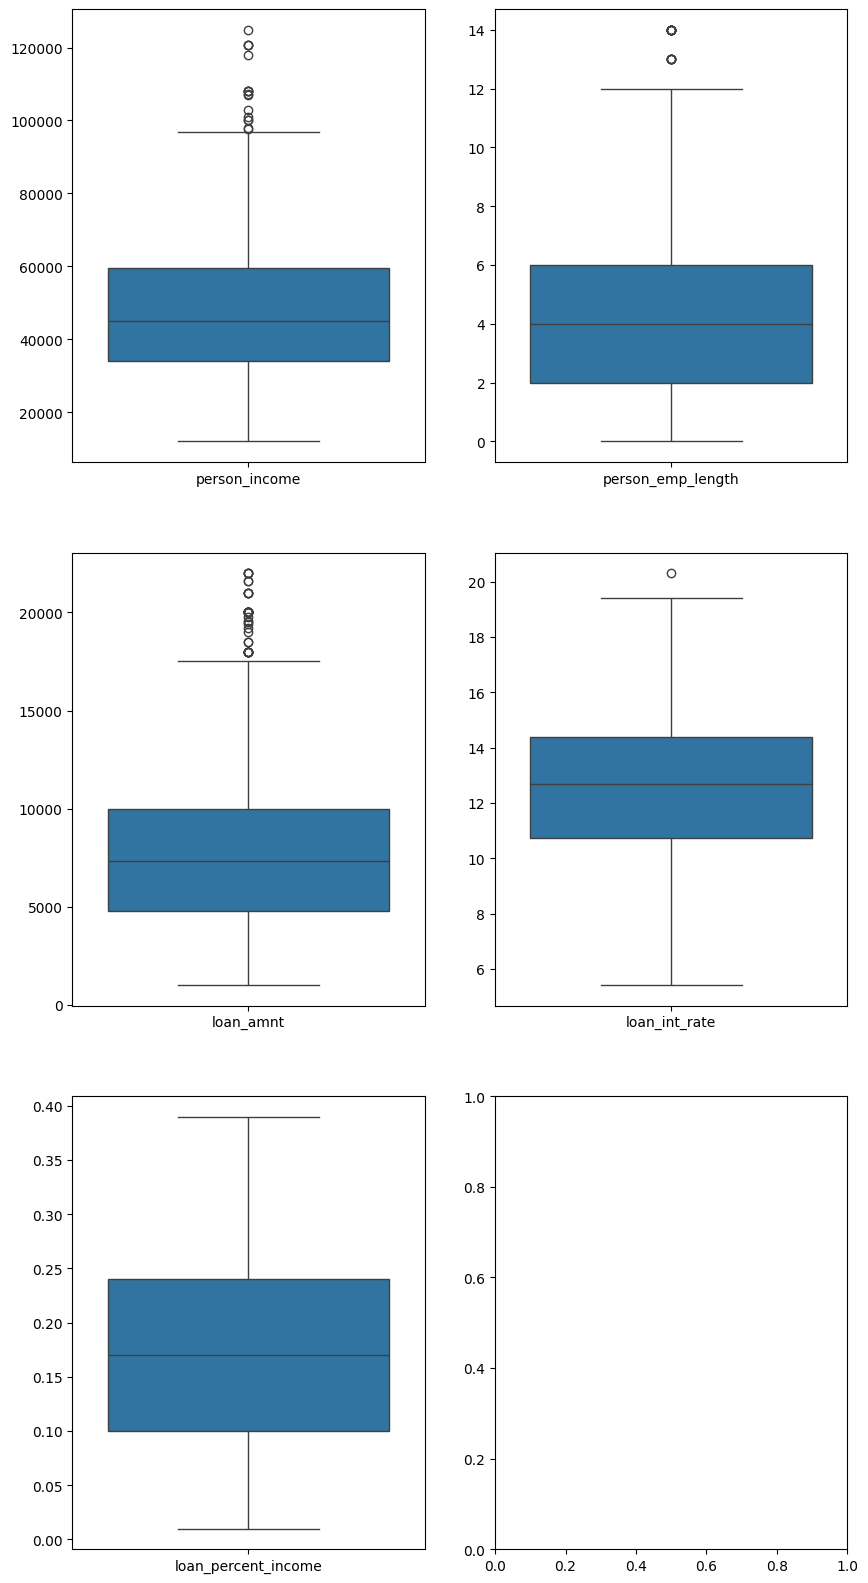

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(5 * 2, 5 * 4))

def box(i):
    plot = sns.boxplot(wrong_preds_xgb[numerical_cols].iloc[:, [i]], ax=axes[i // 2][i % 2])

for i in range(5):
    box(i)

plt.show()

## Ensemble Learning

In [43]:
train_df = pd.read_csv('train.csv',index_col='id')
test_df  = pd.read_csv('test.csv',index_col='id')
target = 'loan_status'
numerical_features=['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate','loan_percent_income','cb_person_cred_hist_length']
categorical_features=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
train_df.drop_duplicates(inplace=True)
for i in train_df.select_dtypes(include='number').columns:
    train_df[i].fillna(train_df[i].median(),inplace=True)
train_df.isnull().sum()
def wisker(col):
    q1,q3=np.percentile(col,[25,75])
    iqr=q3-q1
    lw=q1-1.5*iqr
    uw=q3+1.5*iqr
    return lw,uw
for i in numerical_features:
    lw,uw=wisker(train_df[i])
    train_df[i]=np.where(train_df[i]<lw,lw,train_df[i])
    train_df[i]=np.where(train_df[i]>uw,uw,train_df[i])
X = train_df.drop(target,axis=1)
y = train_df[target]
over = SMOTENC(sampling_strategy = 0.5, categorical_features=[2, 4, 5, 9],\
               k_neighbors = 100, random_state = 42)
# transform the dataset
X, y = over.fit_resample(X, y)
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
test = test_df.copy() 
oe = OrdinalEncoder()
oe.fit(X[categorical_features])
X[categorical_features] = oe.transform(X[categorical_features])
test[categorical_features] = oe.transform(test[categorical_features])

In [44]:
def model_trainer(model, X, y, test, n_splits=10, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    roc_aucs = [] 
    test_pred = np.zeros(len(test))  
    oof_train_preds = np.zeros(len(y))  

    model_name = model[-1].__class__.__name__ if isinstance(model, Pipeline) else model.__class__.__name__
  
    print("="*72)
    print(f"Training {model_name}")
    print("="*72,sep='\n')
    
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        try:
            y_pred_proba = model_clone.predict_proba(X_test)[:,1]
            test_pred += model_clone.predict_proba(test)[:, 1]
        except:
            y_pred_proba = model_clone.predict(X_test)
            test_pred += model_clone.predict(test)
        oof_train_preds[test_idx] = y_pred_proba
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        roc_aucs.append(roc_auc)
        print(f"Fold {fold+1} --> ROC_AUC Score: {roc_auc:.6f}")
        
        del model_clone, X_train, X_test, y_train, y_test
        gc.collect()

    print(f"\nAverage Fold ROC_AUC Score: {np.mean(roc_aucs):.6f} \xb1 {np.std(roc_aucs):.6f}\n")
    return test_pred/skfold.get_n_splits(), oof_train_preds

In [45]:
def convert_to_string(df):
    df_cat = df.copy()  
    df_cat = df_cat.fillna(0)  
    for col in features:  
        df_cat[col] = df_cat[col].astype('string')  
    return df_cat  

In [46]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [47]:
train_preds = {}
test_preds = {}

In [48]:
solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
auc_scores = {}

for solver in solvers:
    oof_aucs = []
    oof_train_preds = np.zeros(len(y))

    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_test, y_test = X.iloc[test_idx], y[test_idx]
        
        log_reg_clf = LogisticRegression(solver=solver, max_iter=1000)
        log_reg_clf.fit(X_train, y_train)
        
        y_pred = log_reg_clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        oof_aucs.append(auc)
        oof_train_preds[test_idx] = y_pred
    
    auc_mean = np.mean(oof_aucs)
    auc_std = np.std(oof_aucs)
    auc_scores[solver] = (auc_mean, auc_std)

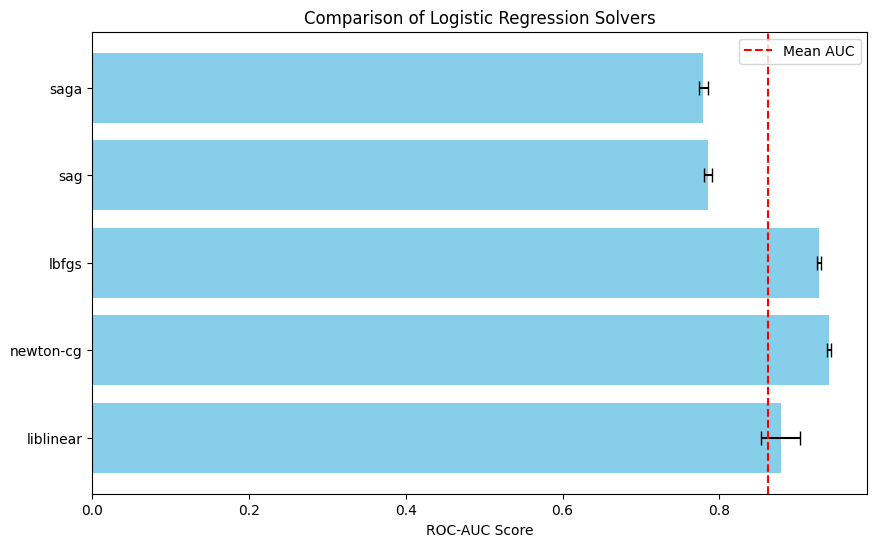

In [49]:
solvers = list(auc_scores.keys())
mean_scores = [score[0] for score in auc_scores.values()]
std_scores = [score[1] for score in auc_scores.values()]

plt.figure(figsize=(10, 6))
plt.barh(solvers, mean_scores, xerr=std_scores, capsize=5, color='skyblue')
plt.xlabel('ROC-AUC Score')
plt.title('Comparison of Logistic Regression Solvers')
plt.axvline(x=np.mean(mean_scores), color='red', linestyle='--', label='Mean AUC')
plt.legend()
plt.show()

In [50]:
oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))

# Logistic Regression
log_reg_params = {
    'solver': 'newton-cg', 
    'max_iter': 1000,
}

for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]
    
    log_reg_clf = LogisticRegression(**log_reg_params)
    log_reg_clf.fit(X_train, y_train)
    
    y_pred = log_reg_clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    oof_aucs.append(auc)
    oof_train_preds[test_idx] = y_pred
    test_preds_log_reg = log_reg_clf.predict_proba(test)[:, 1]
    oof_preds.append(test_preds_log_reg)
    print(f"\nFold {fold + 1} --> Logistic Regression ROC-AUC Score: {auc:.6f}\n")

auc_mean = np.mean(oof_aucs)
auc_std = np.std(oof_aucs)
print(f"\nAverage Fold ROC-AUC Score: {auc_mean:.6f} ± {auc_std:.6f}\n")

train_preds['log_reg'] = oof_train_preds
test_preds['log_reg'] = np.mean(oof_preds, axis=0)


Fold 1 --> Logistic Regression ROC-AUC Score: 0.941940


Fold 2 --> Logistic Regression ROC-AUC Score: 0.942498


Fold 3 --> Logistic Regression ROC-AUC Score: 0.938926


Fold 4 --> Logistic Regression ROC-AUC Score: 0.937488


Fold 5 --> Logistic Regression ROC-AUC Score: 0.939238


Fold 6 --> Logistic Regression ROC-AUC Score: 0.942780


Fold 7 --> Logistic Regression ROC-AUC Score: 0.940578


Fold 8 --> Logistic Regression ROC-AUC Score: 0.941166


Fold 9 --> Logistic Regression ROC-AUC Score: 0.940543


Fold 10 --> Logistic Regression ROC-AUC Score: 0.936266


Average Fold ROC-AUC Score: 0.940142 ± 0.002037



In [51]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors_options = range(1, 11)  # n_neighbors 从 1 到 10
auc_scores = {}

for n_neighbors in n_neighbors_options:
    oof_aucs = []
    oof_train_preds = np.zeros(len(y))

    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_test, y_test = X.iloc[test_idx], y[test_idx]
        
        knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
        knn_clf.fit(X_train, y_train)
        
        y_pred = knn_clf.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)
        oof_aucs.append(auc)
        oof_train_preds[test_idx] = y_pred
    
    auc_mean = np.mean(oof_aucs)
    auc_std = np.std(oof_aucs)
    auc_scores[n_neighbors] = (auc_mean, auc_std)

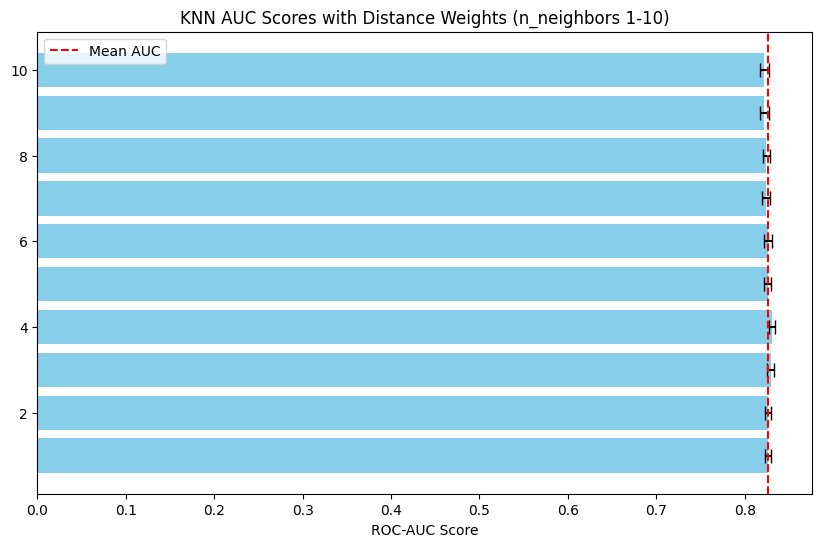

In [52]:
n_neighbors_list = list(auc_scores.keys())
mean_scores = [score[0] for score in auc_scores.values()]
std_scores = [score[1] for score in auc_scores.values()]

plt.figure(figsize=(10, 6))
plt.barh(n_neighbors_list, mean_scores, xerr=std_scores, capsize=5, color='skyblue')
plt.xlabel('ROC-AUC Score')
plt.title('KNN AUC Scores with Distance Weights (n_neighbors 1-10)')
plt.axvline(x=np.mean(mean_scores), color='red', linestyle='--', label='Mean AUC')
plt.legend()
plt.show()

In [53]:
oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))
knn_params = {
    'n_neighbors': 10,
     'weights' :'distance'
}
oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))

for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]
    
    knn_clf = KNeighborsClassifier(**knn_params)
    knn_clf.fit(X_train, y_train)
    
    y_pred = knn_clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    oof_aucs.append(auc)
    oof_train_preds[test_idx] = y_pred
    test_preds_knn = knn_clf.predict_proba(test)[:, 1]
    oof_preds.append(test_preds_knn)
    print(f"\nFold {fold + 1} --> ROC-AUC Score: {auc:.6f}\n")

auc_mean = np.mean(oof_aucs)
auc_std = np.std(oof_aucs)
print(f"\nAverage Fold KNN ROC-AUC Score: {auc_mean:.6f} ± {auc_std:.6f}\n")

train_preds['knn'] = oof_train_preds
test_preds['knn'] = np.mean(oof_preds, axis=0)


Fold 1 --> ROC-AUC Score: 0.920682


Fold 2 --> ROC-AUC Score: 0.915725


Fold 3 --> ROC-AUC Score: 0.916580


Fold 4 --> ROC-AUC Score: 0.912249


Fold 5 --> ROC-AUC Score: 0.920879


Fold 6 --> ROC-AUC Score: 0.918485


Fold 7 --> ROC-AUC Score: 0.916465


Fold 8 --> ROC-AUC Score: 0.916000


Fold 9 --> ROC-AUC Score: 0.915380


Fold 10 --> ROC-AUC Score: 0.912436


Average Fold KNN ROC-AUC Score: 0.916488 ± 0.002780



In [54]:
from sklearn.ensemble import RandomForestClassifier
oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))

# Random Forest
rf_params = {
    'n_estimators': 100,
    'max_depth': None,
    'random_state': 42,
}

for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]
    
    rf_clf = RandomForestClassifier(**rf_params)
    rf_clf.fit(X_train, y_train)
    
    y_pred = rf_clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    oof_aucs.append(auc)
    oof_train_preds[test_idx] = y_pred
    test_preds_rf = rf_clf.predict_proba(test)[:, 1]
    oof_preds.append(test_preds_rf)
    print(f"\nFold {fold + 1} --> ROC-AUC Score: {auc:.6f}\n")

auc_mean = np.mean(oof_aucs)
auc_std = np.std(oof_aucs)
print(f"\nAverage Fold Random Forest ROC-AUC Score: {auc_mean:.6f} ± {auc_std:.6f}\n")

train_preds['rf'] = oof_train_preds
test_preds['rf'] = np.mean(oof_preds, axis=0)


Fold 1 --> ROC-AUC Score: 0.979419


Fold 2 --> ROC-AUC Score: 0.979407


Fold 3 --> ROC-AUC Score: 0.977577


Fold 4 --> ROC-AUC Score: 0.974472


Fold 5 --> ROC-AUC Score: 0.977532


Fold 6 --> ROC-AUC Score: 0.977692


Fold 7 --> ROC-AUC Score: 0.982285


Fold 8 --> ROC-AUC Score: 0.979581


Fold 9 --> ROC-AUC Score: 0.975471


Fold 10 --> ROC-AUC Score: 0.977747


Average Fold Random Forest ROC-AUC Score: 0.978118 ± 0.002100



In [55]:
test_preds_df = pd.DataFrame(test_preds)
train_preds_df = pd.DataFrame(train_preds)

In [56]:
ridge = Ridge(positive=True, tol=1e-6)

ridge_pred_stack, _ = model_trainer(ridge, train_preds_df, y, test_preds_df,random_state=101)

Training Ridge
Fold 1 --> ROC_AUC Score: 0.979944
Fold 2 --> ROC_AUC Score: 0.982266
Fold 3 --> ROC_AUC Score: 0.981924
Fold 4 --> ROC_AUC Score: 0.981244
Fold 5 --> ROC_AUC Score: 0.979667
Fold 6 --> ROC_AUC Score: 0.982683
Fold 7 --> ROC_AUC Score: 0.977896
Fold 8 --> ROC_AUC Score: 0.983213
Fold 9 --> ROC_AUC Score: 0.981445
Fold 10 --> ROC_AUC Score: 0.983059

Average Fold ROC_AUC Score: 0.981334 ± 0.001615



## Saving

In [57]:
sub = pd.read_csv('sample_submission.csv')
sub[target] = ridge_pred_stack
sub.to_csv('loan_pred_submission.csv', index=False)